In [144]:
# Imports
import csv
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pickle
from datetime import datetime
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
import time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from utils import load_sf_cell_towers, load_sf_cabs_time_index, load_mini_sf_cabs, plot_links_bw_consumption, plot_cell_tower_ingress, plot_ensemble

## Load Datasets

In [58]:
SF_CELL_TOWERS = "20nodes_sf_cell_towers.csv"

cell_tower_ids, cell_tower_locations = load_sf_cell_towers(SF_CELL_TOWERS, outliers_removed=True) # outliers removed, 17 towers
time_index = load_mini_sf_cabs() # first hour – 3578 timestamps # At most 13 cars at concurrent timestamp in the first hour, total 328 cars

# *cell_tower used interchangeably with edge_node

In [56]:
time_index = load_sf_cabs_time_index('time_index.pkl', start=0, end=12, write=True)

100%|██████████| 2023603/2023603 [00:01<00:00, 1717638.21it/s]


In [72]:
### make a kd-tree with the cell tower locations to quickly find nearest edge node
edge_node_tree = KDTree(cell_tower_locations, leaf_size=2)

# Policy Evaluation
Evaluate three baseline policies and measure bandwidth consumption.
Datasets: SF Cabs (1 h subset) + SF Cell Towers (outliers removed)

1. The filter function is placed at the closest node to the car at t=0. This does not change. As the car moves, there may be data transmission from a new "closest node" to the filter function node.

2. The filter function is always placed to the node closest to the car at the current timestamp. 

3. The filter function is on the closest node. Stitch function placement updates whenever filter function position updates.

- Stitch function locations are determined as K-Means on the filter function locations. 
- For P1 and P2, stitch function location does not change. 
- For P2 and P3, filter function is always on the closest node. 

In [150]:
FIRST_HOP_DATA = 10 # car to filter function edge node (1 per car)
SECOND_HOP_DATA = 5 # filter function to first stitch function 
THIRD_HOP_DATA = 5 # first stitch function to second (final) stitch function

meta = FIRST_HOP_DATA, SECOND_HOP_DATA, THIRD_HOP_DATA

## Policy 1

In [170]:
from policies.static_filter_stitch import policy as policy1
edge_bw_1, links_bw_1 = policy1(time_index, cell_tower_ids, cell_tower_locations, edge_node_tree, meta)                

100%|██████████| 3601/3601 [00:01<00:00, 1829.45it/s]

defaultdict(<class 'int'>, {(2, 10): 4590, (10, 4): 42515, (14, 4): 7710, (4, 4): 25475, (3, 3): 12660, (3, 4): 21425, (0, 10): 32325, (6, 3): 6595, (10, 10): 8065, (12, 5): 945, (5, 4): 1555, (1, 8): 425, (8, 4): 1320, (8, 8): 635, (9, 10): 2675, (13, 8): 420, (5, 5): 730, (7, 4): 625, (0, 3): 6150, (6, 0): 2990, (4, 3): 2710, (3, 0): 9690, (10, 0): 3800, (15, 4): 540, (10, 2): 530, (0, 6): 2910, (3, 6): 1600, (1, 13): 50, (0, 4): 3630, (4, 0): 6300, (2, 14): 130, (0, 2): 1190, (2, 0): 3410, (9, 2): 230, (4, 7): 220, (4, 14): 240, (2, 3): 1390, (12, 8): 60, (14, 0): 3410, (12, 4): 330, (4, 2): 940, (14, 2): 900, (2, 9): 300, (14, 10): 1310, (15, 14): 70, (10, 14): 190, (4, 10): 1660, (14, 3): 1930, (3, 10): 3070, (15, 8): 100, (13, 1): 80, (0, 14): 720, (3, 2): 1570, (10, 6): 680, (7, 0): 50, (12, 14): 100, (12, 3): 240, (2, 4): 910, (0, 9): 590, (4, 8): 250, (3, 5): 590, (10, 3): 910, (9, 0): 1400, (15, 3): 160, (8, 14): 90, (14, 9): 440, (12, 2): 120, (2, 6): 630, (13, 14): 250, (12

86 links used.


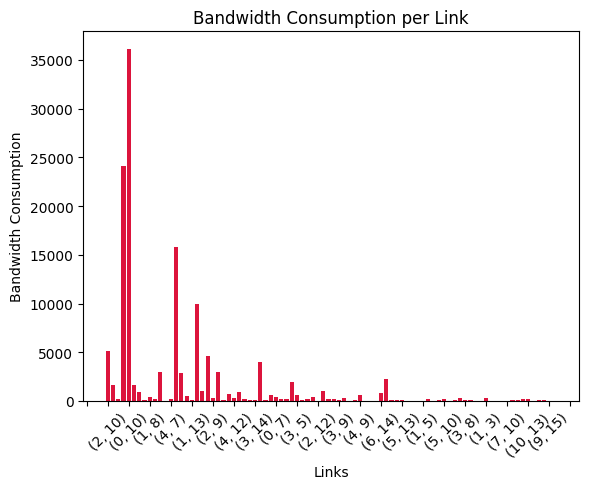

In [213]:
plot_links_bw_consumption(links_bw_1, 1, 1, 1, space=4)

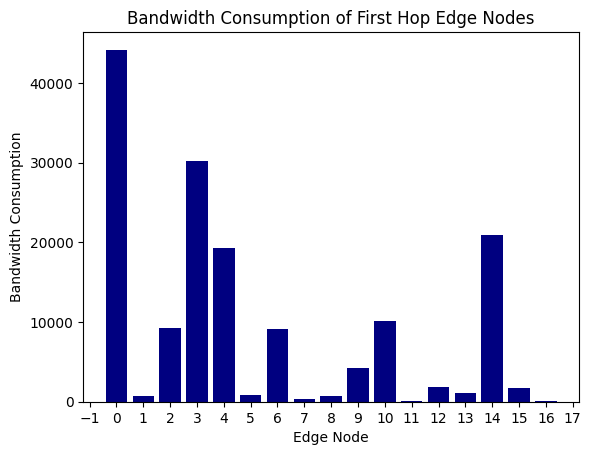

In [210]:
plot_cell_tower_ingress(edge_bw_1)  # would be the same for policies 2 and 3 as car connects to closest cell_tower

## Policy 2

In [181]:
from policies.moving_filter_static_stitch import policy as policy2
edge_bw_2, links_bw_2 = policy2(time_index, cell_tower_ids, cell_tower_locations, edge_node_tree, meta)

100%|██████████| 3601/3601 [00:01<00:00, 1846.02it/s]

defaultdict(<class 'int'>, {(2, 10): 4610, (10, 4): 33850, (14, 4): 10455, (4, 4): 30745, (3, 3): 15125, (3, 4): 19700, (0, 10): 22090, (6, 3): 4575, (10, 10): 5035, (12, 5): 930, (5, 4): 1395, (1, 8): 375, (8, 4): 1335, (8, 8): 385, (9, 10): 2115, (13, 8): 550, (5, 5): 450, (7, 4): 195, (15, 4): 855, (11, 5): 15, (16, 8): 25})
defaultdict(<class 'int'>, {(2, 10): 4610, (4, 10): 33850, (4, 14): 10455, (3, 4): 19700, (0, 10): 22090, (3, 6): 4575, (5, 12): 930, (4, 5): 1395, (1, 8): 375, (4, 8): 1335, (9, 10): 2115, (8, 13): 550, (4, 7): 195, (4, 15): 855, (5, 11): 15, (8, 16): 25})


16 links used.


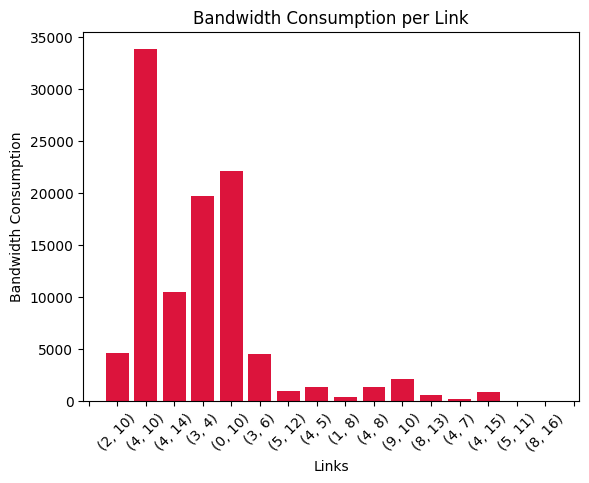

In [214]:
plot_links_bw_consumption(links_bw_2, 1, 1, 1)

## Policy 3

In [189]:
from policies.moving_filter_stitch import policy as policy3
edge_bw_3, links_bw_3 = policy3(time_index, cell_tower_ids, cell_tower_locations, edge_node_tree, meta)
                

100%|██████████| 3601/3601 [00:22<00:00, 161.12it/s]

Placement updated 1472 times.


44 links used.


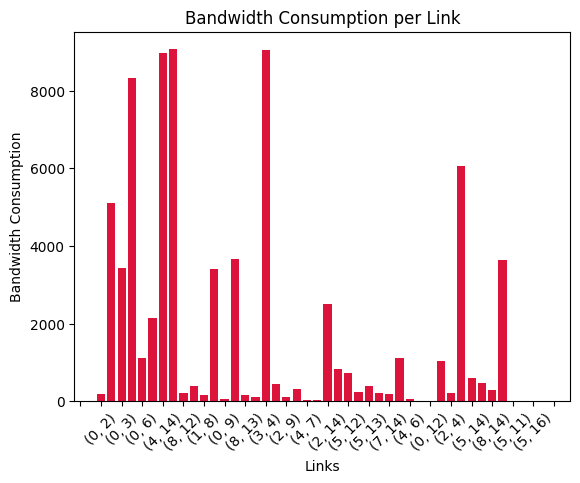

In [215]:
plot_links_bw_consumption(links_bw_3, 1, 1, 1, space=2)

86 links used.
16 links used.
44 links used.


/Users/kartik/Documents/fa23/research/fe_dag/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_ylabel("Bandwidth Consumption")
/Users/kartik/Documents/fa23/research/fe_dag/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_ylabel("Bandwidth Consumption")
/Users/kartik/Documents/fa23/research/fe_dag/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_ylabel("Bandwidth Consumption")


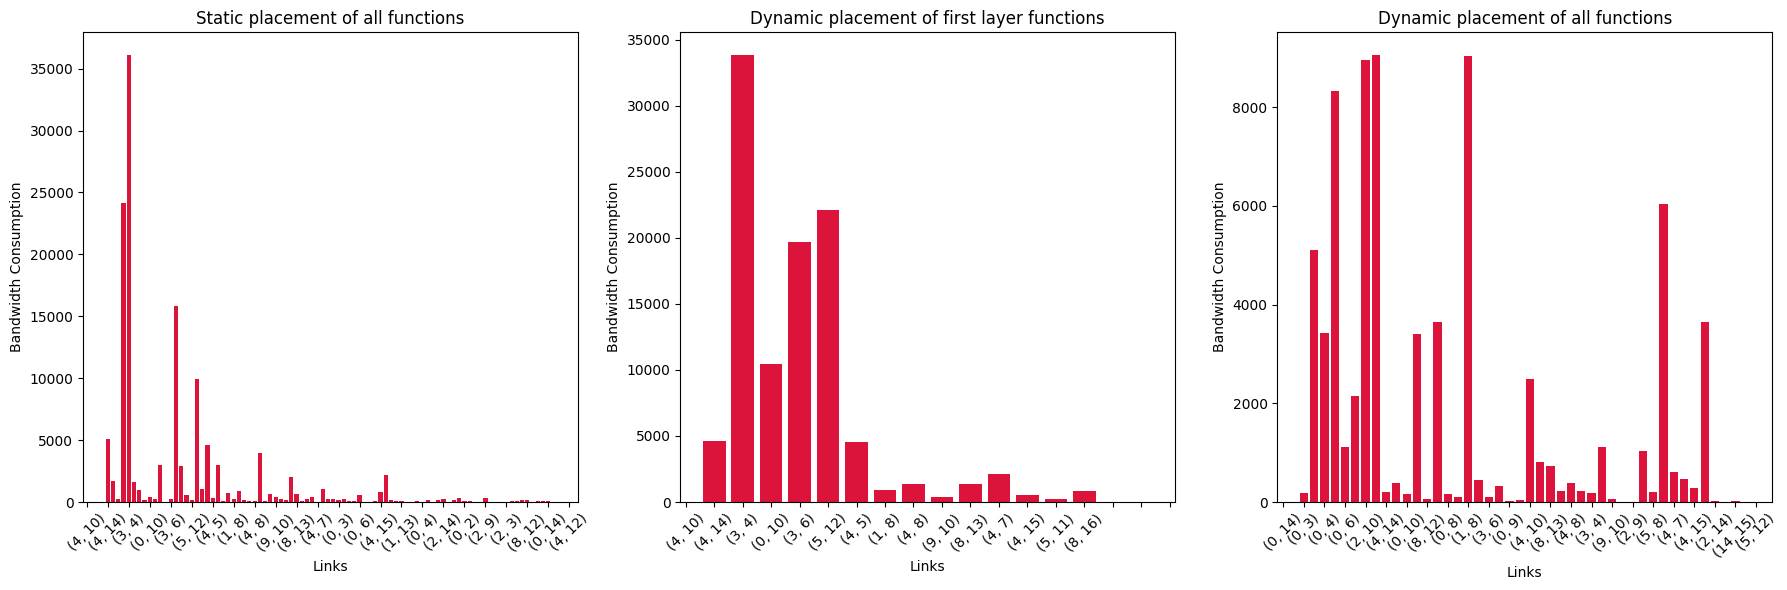

In [230]:
links_bw = [
    (links_bw_1, "Static placement of all functions", 4),
    (links_bw_2, "Dynamic placement of first layer functions", 1),
    (links_bw_3, "Dynamic placement of all functions", 2)
]
plot_ensemble(links_bw)